In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/labeled_data.csv")
data = df.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "PART_FACT_SERIAL",
                        "EQUIP_NAME", "EQUIP_CD", "Reason", "Clamp_Open_Position",
                        "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
                        "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
                        "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7","Switch_Over_Position"])

In [3]:
data["PART_NAME"].unique()

array(["CN7 W/S SIDE MLD'G RH", "CN7 W/S SIDE MLD'G LH",
       "RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH",
       'SP2 CVR ROOF RACK CTR, RH', "JX1 W/S SIDE MLD'G RH"], dtype=object)

In [4]:
rg3 = data[(data["PART_NAME"] =="CN7 W/S SIDE MLD'G RH") | (data["PART_NAME"] =="CN7 W/S SIDE MLD'G LH")]

In [5]:
rg3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1256 entries, 1211 to 5231
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PART_NAME                 1256 non-null   object 
 1   PassOrFail                1256 non-null   object 
 2   Injection_Time            1256 non-null   float64
 3   Filling_Time              1256 non-null   float64
 4   Plasticizing_Time         1256 non-null   float64
 5   Cycle_Time                1256 non-null   float64
 6   Clamp_Close_Time          1256 non-null   float64
 7   Cushion_Position          1256 non-null   float64
 8   Plasticizing_Position     1256 non-null   float64
 9   Max_Injection_Speed       1256 non-null   float64
 10  Max_Screw_RPM             1256 non-null   float64
 11  Average_Screw_RPM         1256 non-null   float64
 12  Max_Injection_Pressure    1256 non-null   float64
 13  Max_Switch_Over_Pressure  1256 non-null   float64
 14  Max_Back_P

In [6]:
rg3 = rg3.drop(columns=["PART_NAME"])
rg3 = rg3.replace("Y", 1).replace("N", 0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16020\2919998673.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rg3 = rg3.replace("Y", 1).replace("N", 0)


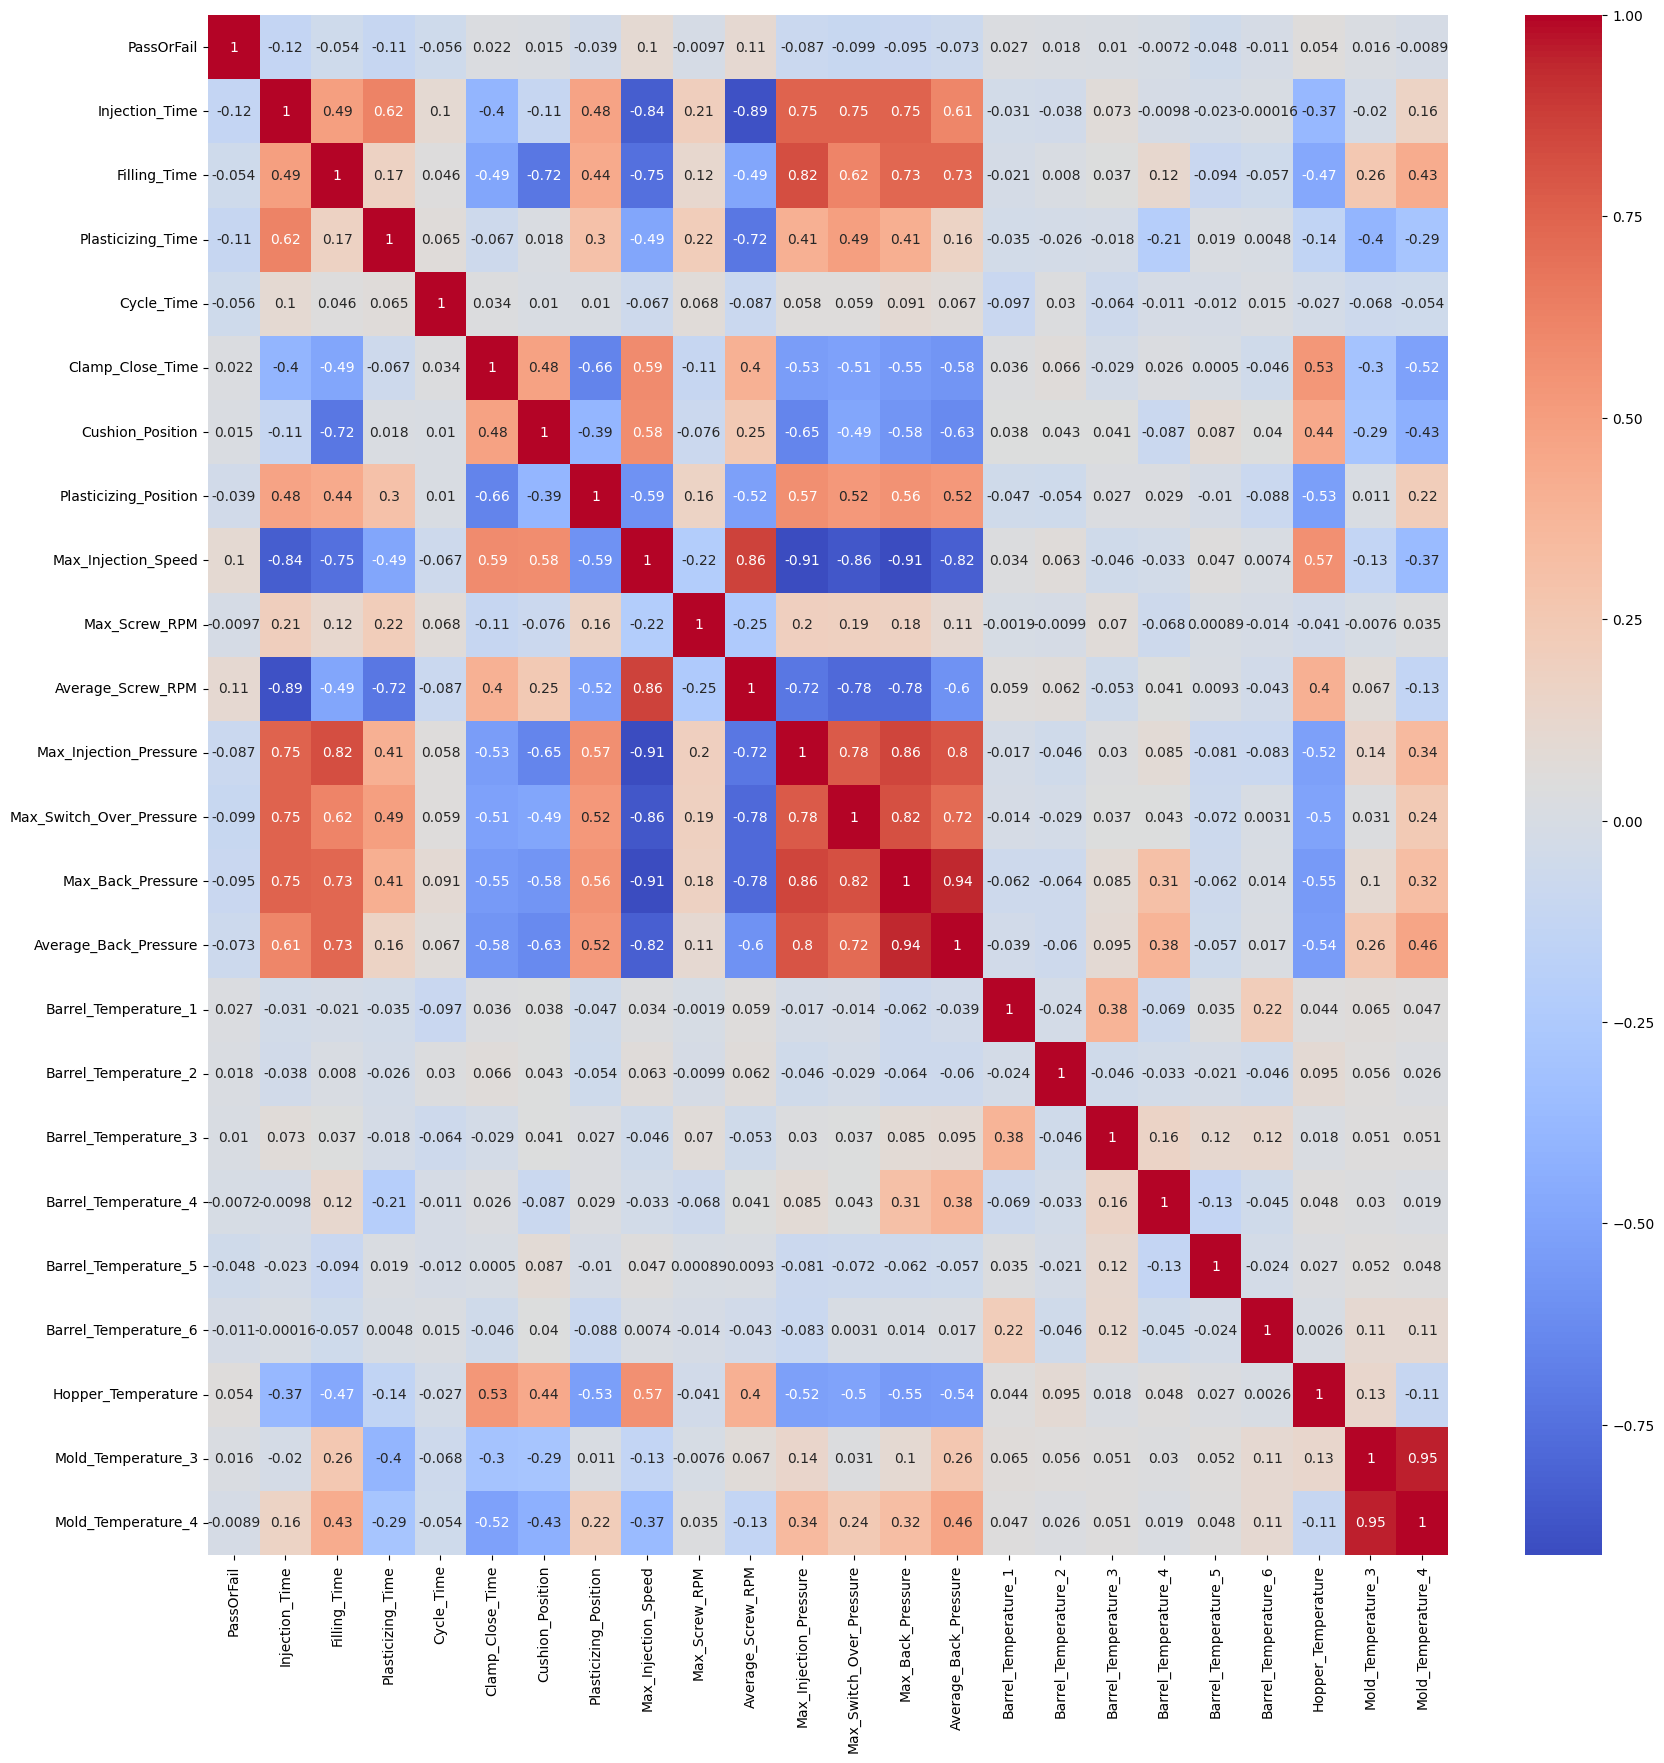

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(rg3.corr(), annot=True, cmap='coolwarm')
plt.show()

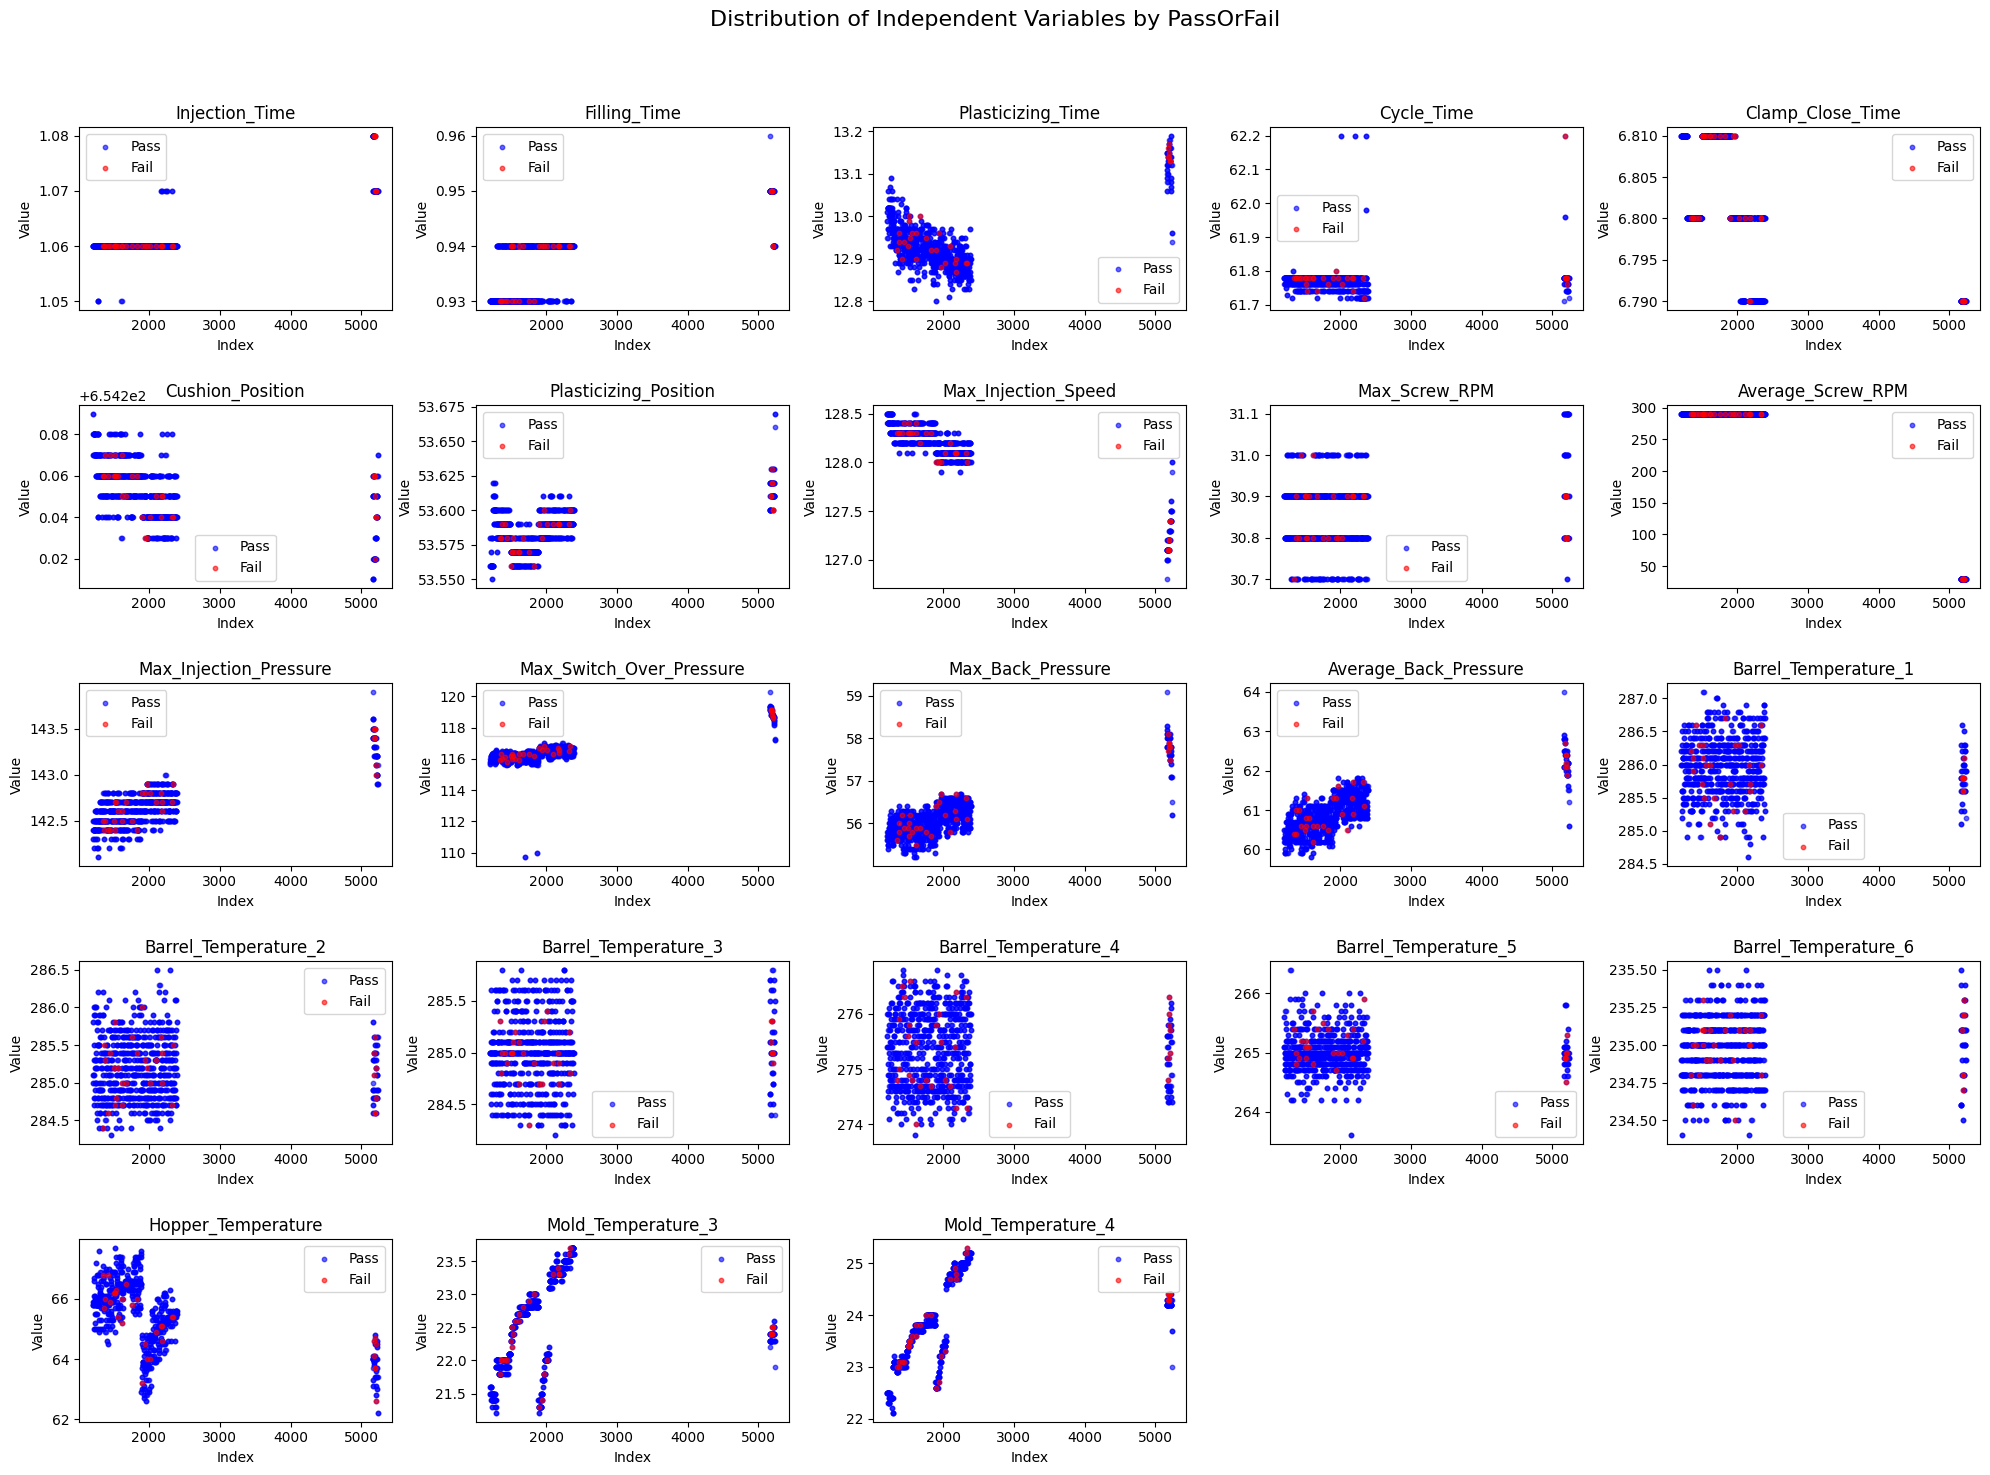

In [8]:
# 독립 변수와 종속 변수 분
y = rg3["PassOrFail"]
X = rg3.drop(columns=["PassOrFail"])

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [9]:
rg3[rg3["Average_Screw_RPM"] < 30]["PassOrFail"].value_counts()

PassOrFail
1    67
0     7
Name: count, dtype: int64

In [10]:
rg3 = rg3[rg3["Average_Screw_RPM"] > 30]

In [12]:

def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df


col_list = ["Max_Switch_Over_Pressure", "Cycle_Time"]

rg3_removed = rg3.copy()

for col in col_list:
    rg3_removed = remove_outliers(rg3_removed, col)

    

In [13]:
rg3_removed["PassOrFail"].value_counts()

PassOrFail
1    1088
0      24
Name: count, dtype: int64

In [14]:
rg3.columns

Index(['PassOrFail', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

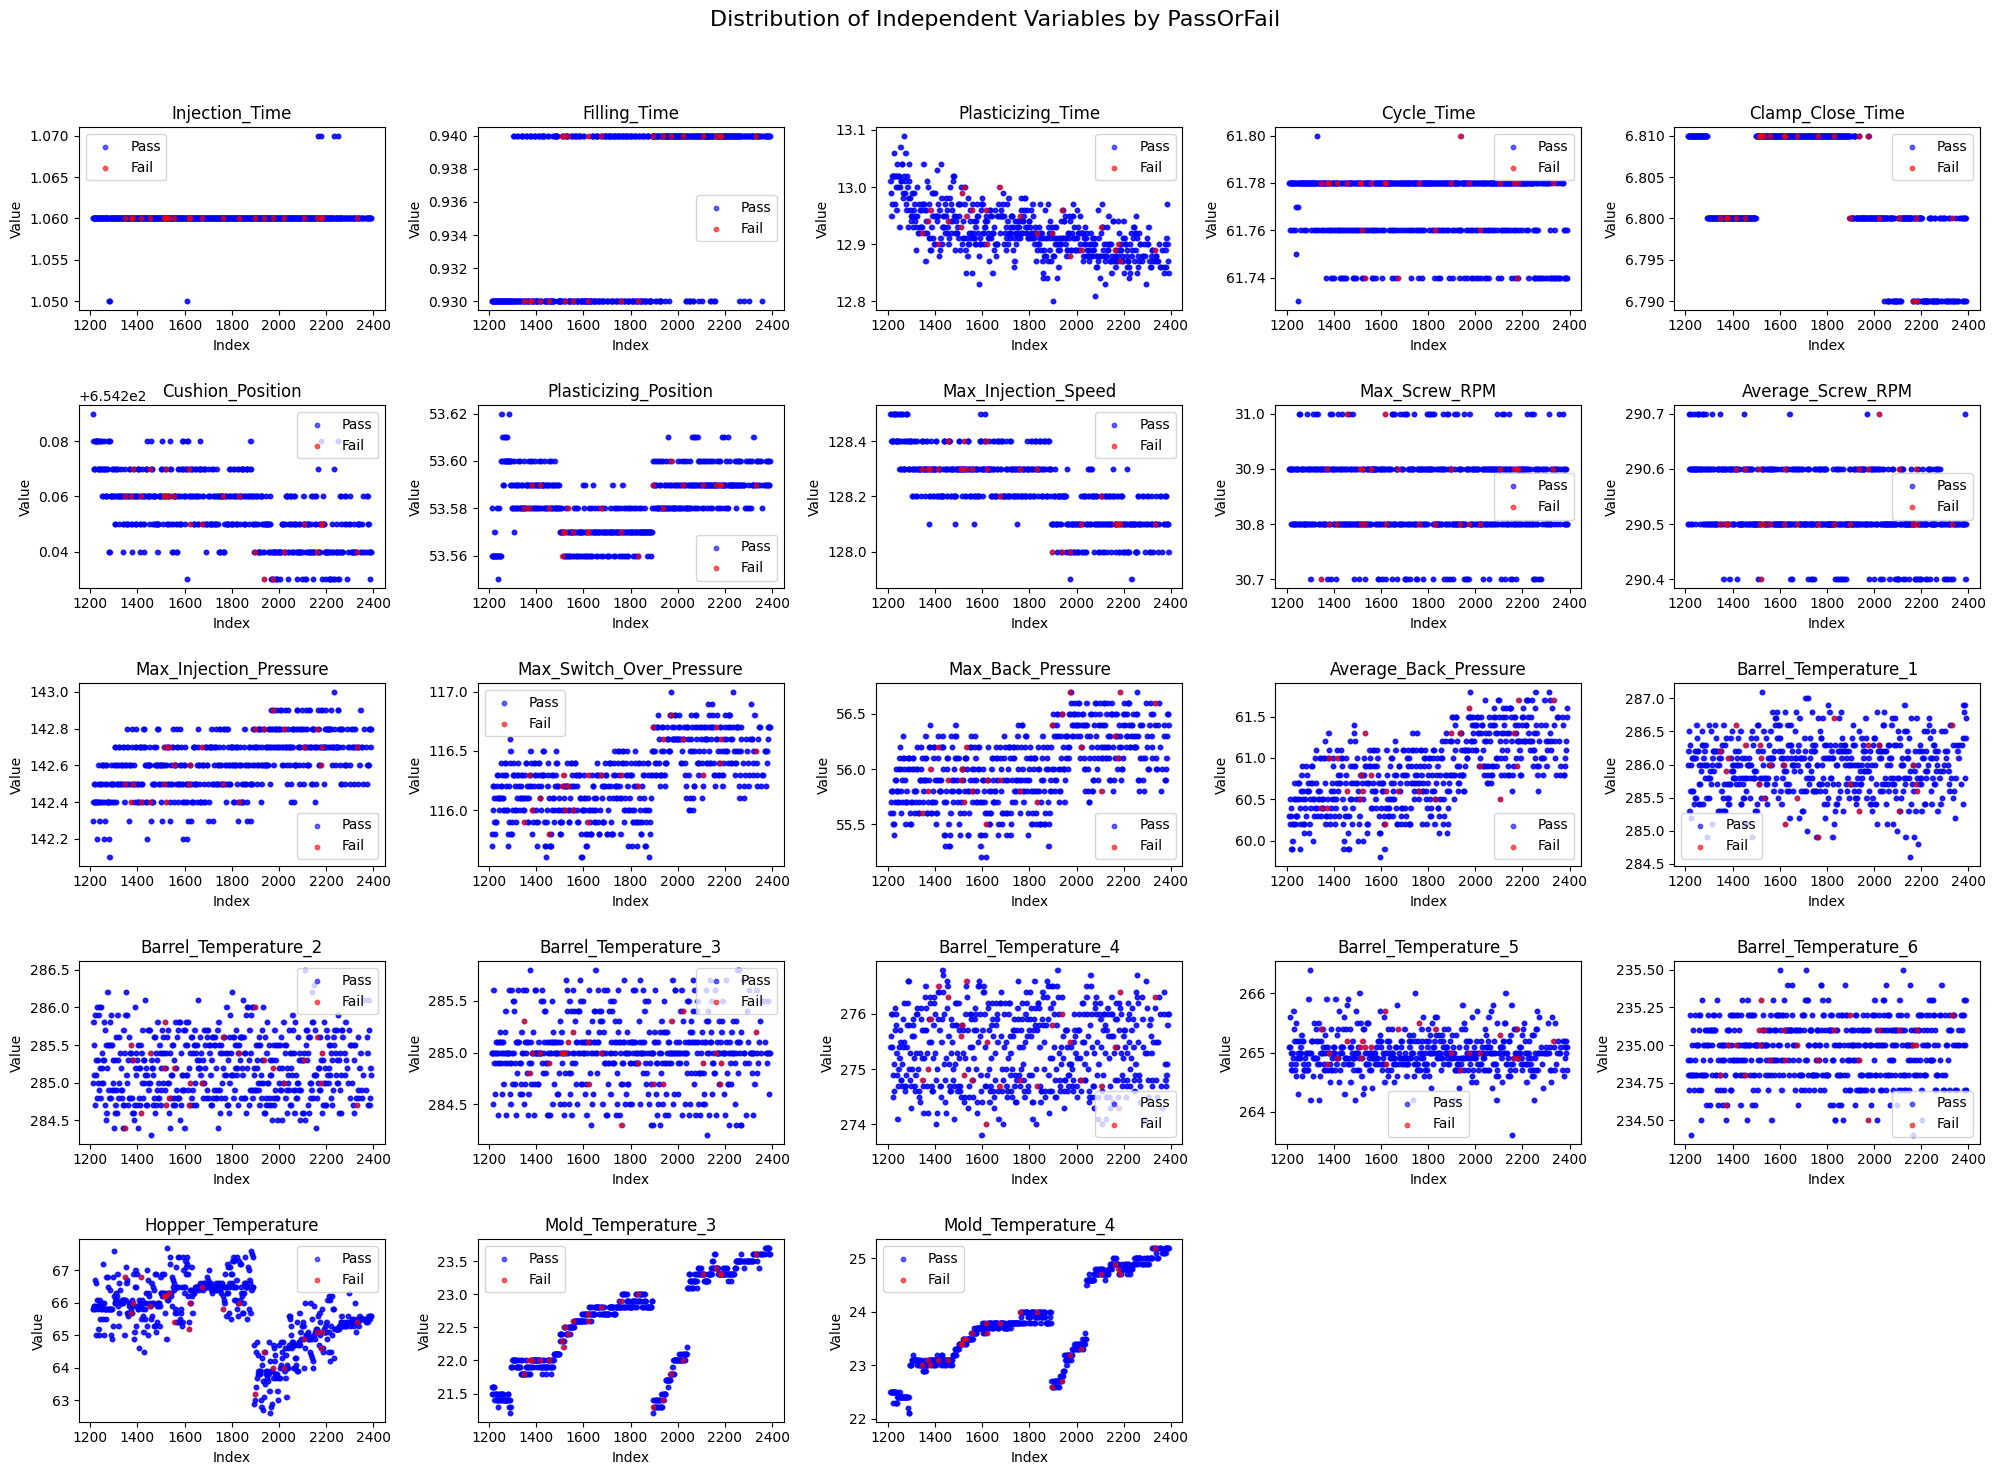

In [16]:
# 독립 변수와 종속 변수 분
y = rg3_removed["PassOrFail"]
X = rg3_removed.drop(columns=["PassOrFail"])

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


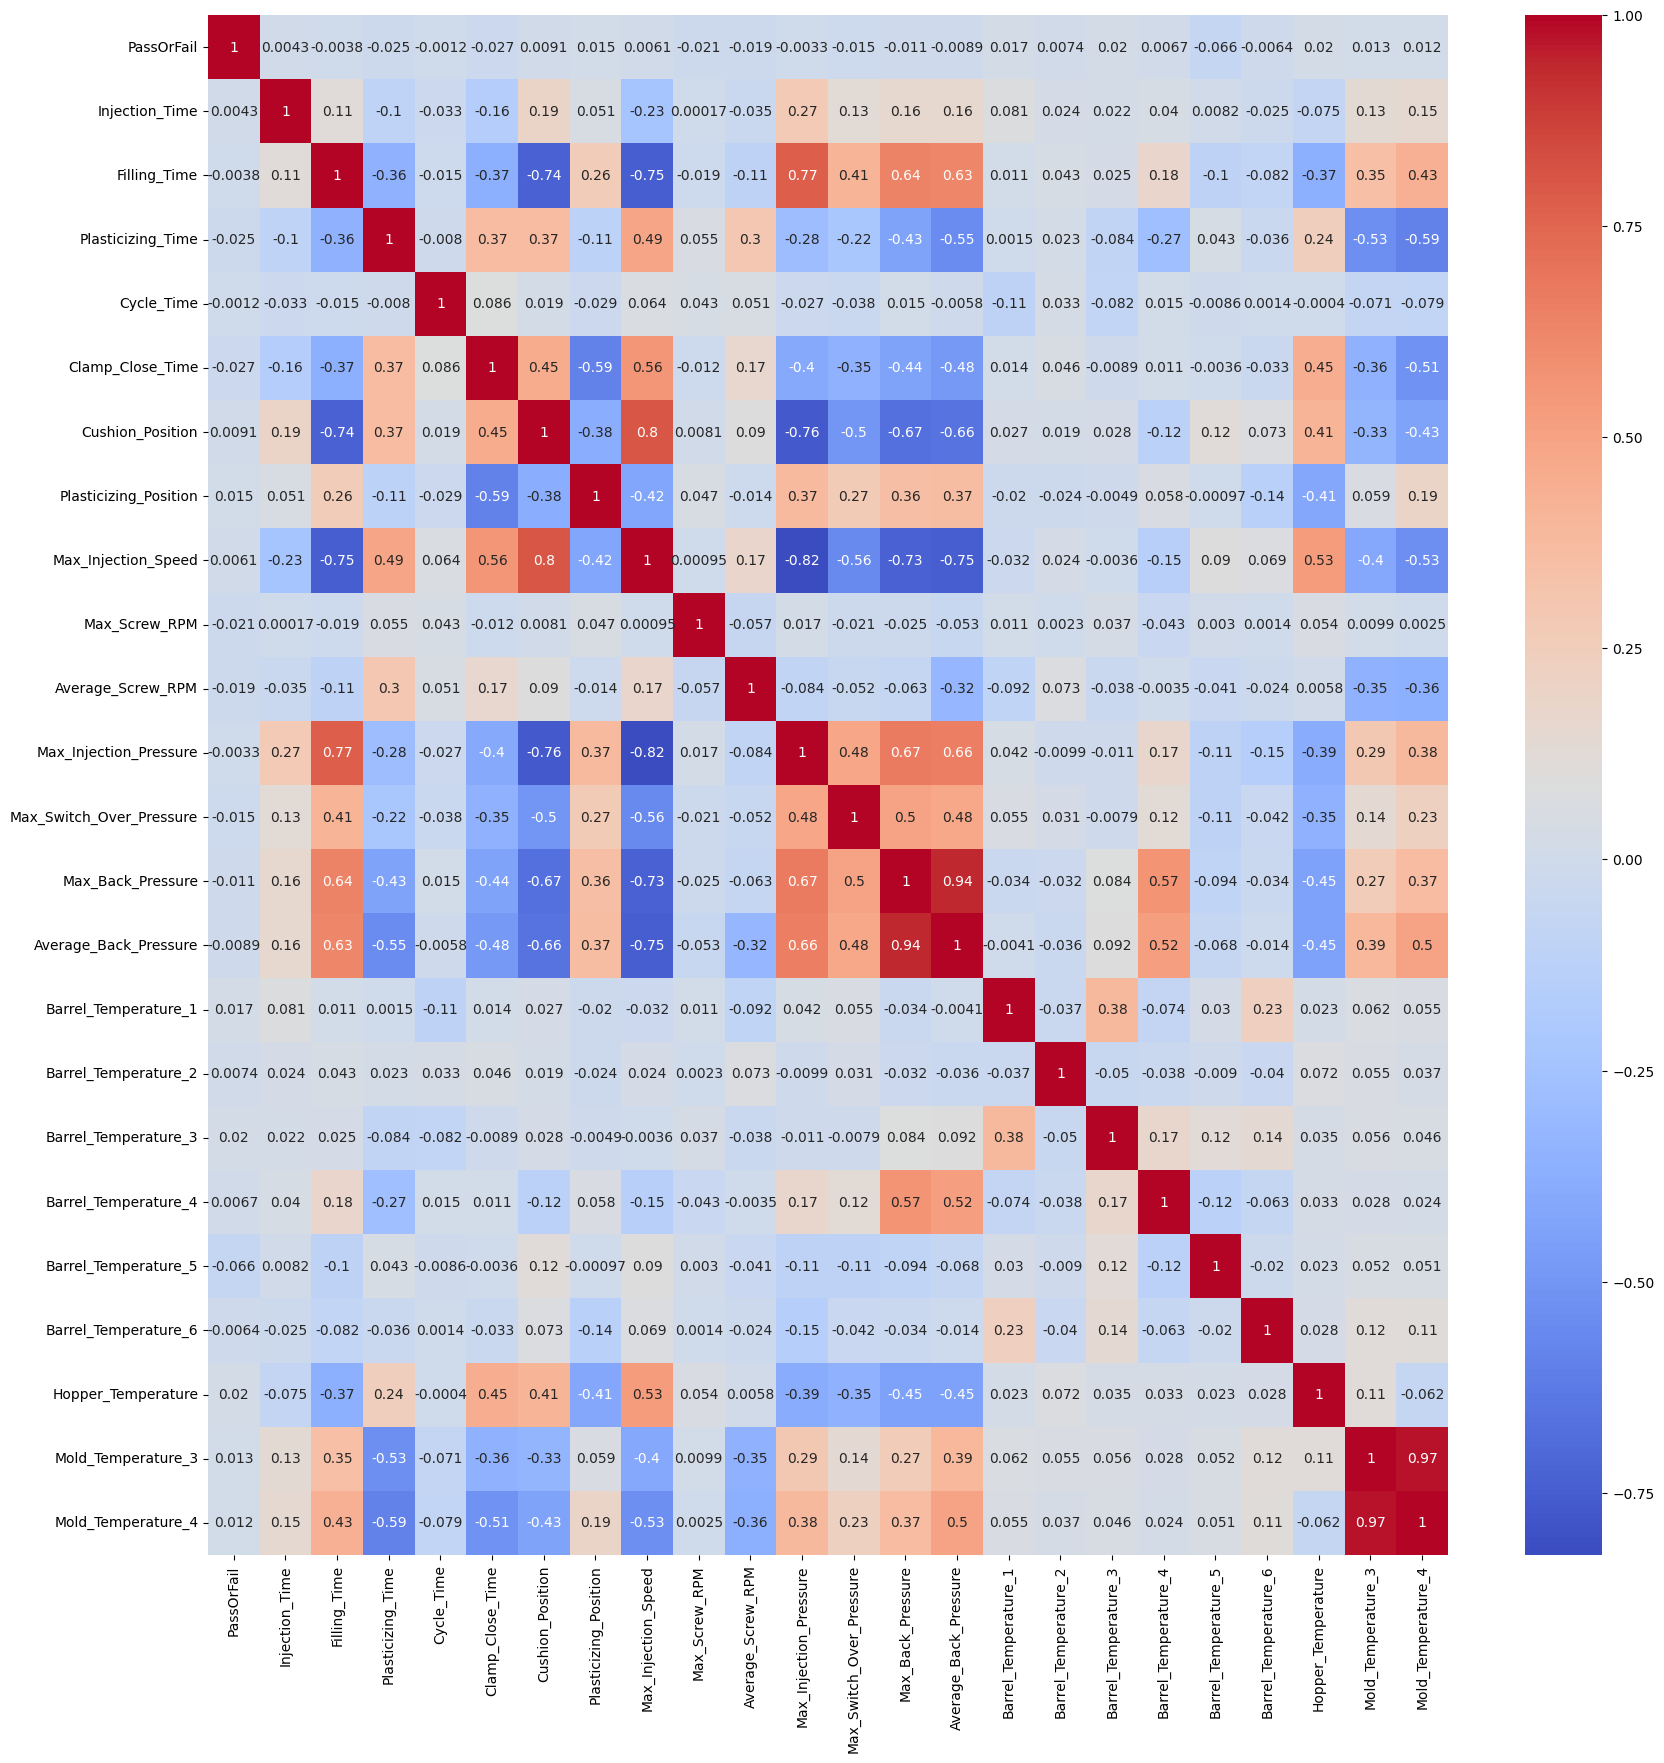

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(rg3.corr(), annot=True, cmap='coolwarm')
plt.show()

In [18]:
rg3_removed = rg3_removed.drop(columns=["Injection_Time"])

In [ ]:
from scipy.stats import spearmanr, pearsonr
y = rg3["PassOrFail"]
X = rg3.drop(columns=["PassOrFail"])
for col_name in X.columns:
    print(col_name)
    print("피어슨")
    print(pearsonr(X[col_name], y))
    print("스피어만")
    print(spearmanr(X[col_name], y))
    print("==================================================================")

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = rg3_removed["PassOrFail"]
X = rg3_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [22]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.994382,0.986900,0.981818,0.990826,0.986301,0.007482,0,9,4,321,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.994382,0.991266,1.000000,0.981651,0.990741,0.003116,0,9,7,318,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.995318,0.975983,0.964126,0.986239,0.975057,0.019336,0,9,5,320,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
3,HistGradientBoostingClassifier,0.995318,0.980349,0.972851,0.986239,0.979499,0.014969,0,9,5,320,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.995318,0.980349,0.972851,0.986239,0.979499,0.014969,0,9,5,320,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."
